This code builds a synthetic imbalanced dataset and runs several classifiers to test different metrics and data augmentation strategies.  
We compute metrics on training set and on hold-out set.  
There is no hyperparameter optimisation.  

In [1]:
# all the imports

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification

from sklearn.decomposition import PCA

from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import balanced_accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier

rng = np.random.RandomState(0)

In [2]:
# synthetic data in 20D or 2D with 10k samples and 5% imbalance


def generate_data_20d():
    X, y = make_classification(
        n_samples=10000,
        n_features=20,
        n_informative=16,
        n_redundant=2,
        n_repeated=2,
        n_classes=2,
        weights=[0.95, 0.05],
        random_state=rng,
    )
    return X, y


def generate_data_2d():
    X, y = make_classification(
        n_samples=10000,
        n_features=2,
        n_informative=2,
        n_redundant=0,
        n_repeated=0,
        n_classes=2,
        weights=[0.95, 0.05],
        random_state=rng,
    )
    return X, y


# X, y = generate_data_2d()
X, y = generate_data_20d()

PCA: Top 2 components explain 54% of variance


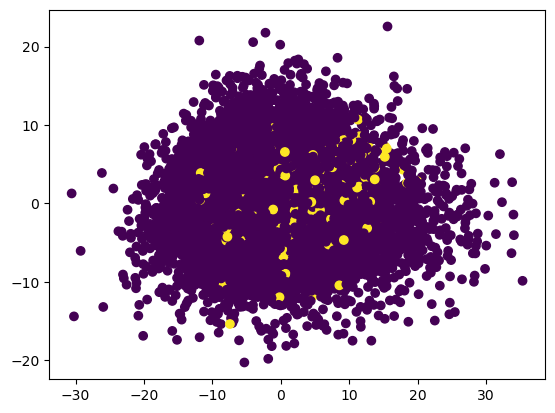

In [3]:
# plot the data
if X.shape[1] != 2:
    # if more than 2 dimensions
    # make a PCA and plot 2 top components
    pca = PCA(n_components=2)
    components = pca.fit_transform(X)

    total_var = pca.explained_variance_ratio_.sum() * 100
    print(f"PCA: Top 2 components explain {total_var:.0f}% of variance")

    plt.scatter(components[:, 0], components[:, 1], c=y)
else:
    # otherwise simply plot 2d data as scatter plot
    plt.scatter(X[:, 0], X[:, 1], c=y)

In [4]:
# metrics routine


def metrics(X, y, clf):
    y_hat = clf.predict(X)
    ret_metrics = []
    ret_metrics.append(accuracy_score(y, y_hat))
    ret_metrics.append(precision_score(y, y_hat, zero_division=0))
    ret_metrics.append(recall_score(y, y_hat))
    ret_metrics.append(f1_score(y, y_hat))
    ret_metrics.append(fbeta_score(y, y_hat, beta=0.5))
    ret_metrics.append(balanced_accuracy_score(y, y_hat))
    return ret_metrics


# training routine
def train_standard(X, y, clf):

    model = clf

    # we store metrics there before averaging at the end
    accuracy_list = []
    precision_list = []
    recall_list = []
    f1score_list = []
    fbetascore_list = []
    balanced_accuracy_list = []

    # Defines Stratified K-fold in order to keep
    # the class balance for each fold
    st_k_fold = StratifiedKFold(n_splits=4)

    # get metrics for each fold
    for train_idx, test_idx in st_k_fold.split(X, y):

        # Training fold
        x_train_fold = X[train_idx]
        y_train_fold = y[train_idx]

        # Testing fold
        x_test_fold = X[test_idx]
        y_test_fold = y[test_idx]

        # Train
        model.fit(x_train_fold, y_train_fold)

        # Get metrics
        fold_metrics = metrics(x_test_fold, y_test_fold, model)

        # Save metrics
        accuracy_list.append(fold_metrics[0])
        precision_list.append(fold_metrics[1])
        recall_list.append(fold_metrics[2])
        f1score_list.append(fold_metrics[3])
        fbetascore_list.append(fold_metrics[4])
        balanced_accuracy_list.append(fold_metrics[5])

    # compute average metrics
    metrics_train = []
    metrics_train.append(np.mean(accuracy_list))
    metrics_train.append(np.mean(precision_list))
    metrics_train.append(np.mean(recall_list))
    metrics_train.append(np.mean(f1score_list))
    metrics_train.append(np.mean(fbetascore_list))
    metrics_train.append(np.mean(balanced_accuracy_list))

    # retrain on the whole train dataset
    model.fit(X, y)
    return (model, metrics_train)

In [5]:
# try different data augmentation strategies.
# returns size of dataset, trained model, and metrics.

# trains the classifier without touching the data.
def no_resampling(x, y, clf):
    return (x.shape[0], train_standard(x, y, clf))


# Applies Random Undersampling then trains the classifier
def under_sampler(x, y, clf):
    rus = RandomUnderSampler(random_state=rng)
    rx, ry = rus.fit_resample(x, y)
    return (rx.shape[0], train_standard(rx, ry, clf))


# Applies Random Oversampling then trains the classifier
def over_sampler(x, y, clf):
    ros = RandomOverSampler(random_state=rng)
    rx, ry = ros.fit_resample(x, y)
    return (rx.shape[0], train_standard(rx, ry, clf))


# Applies Synthetic Data Augmentation through SMOTE then trains the classifier
def smote(x, y, clf):
    smote = SMOTE(random_state=rng)
    rx, ry = smote.fit_resample(x, y)
    return (rx.shape[0], train_standard(rx, ry, clf))

In [6]:
# experiment!

# we have X and y, let's build the hold out
X_train, X_hold, y_train, y_hold = train_test_split(
    X, y, test_size=0.10, random_state=rng, stratify=y
)
size_hold_out = X_hold.shape[0]

# these are all the classifiers we want to test
clfs = []
clfs.append(DecisionTreeClassifier(max_depth=3, random_state=rng))
clfs.append(
    DecisionTreeClassifier(max_depth=3, class_weight="balanced", random_state=rng)
)
clfs.append(RandomForestClassifier(max_depth=3, random_state=rng))
clfs.append(
    RandomForestClassifier(max_depth=3, class_weight="balanced", random_state=rng)
)
clfs.append(make_pipeline(StandardScaler(), SVC(gamma="auto", random_state=rng)))
clfs.append(
    make_pipeline(
        StandardScaler(), SVC(gamma="auto", class_weight="balanced", random_state=rng)
    )
)
clfs.append(BalancedRandomForestClassifier(n_estimators=100, random_state=rng))

# loop on classifiers, train them, get metrics on train set and hold out, and print all this out.

for clf in clfs:
    print(
        f"Model            t_acc t_pre t_rec t_f1  t_fb  t_bac t_size\
    h_acc h_pre h_rec h_f1  h_fb  h_bac h_size"
    )
    #
    (size_train, (best_clf, metrics_train)) = no_resampling(X_train, y_train, clf)
    metrics_hold_out = metrics(X_hold, y_hold, best_clf)
    print(
        f"{str(clf)[0:10]} n/a   {metrics_train[0]:.3f} {metrics_train[1]:.3f} {metrics_train[2]:.3f} {metrics_train[3]:.3f} {metrics_train[4]:.3f} {metrics_train[5]:.3f} {size_train:>5d} \
    {metrics_hold_out[0]:.3f} {metrics_hold_out[1]:.3f} {metrics_hold_out[2]:.3f} {metrics_hold_out[3]:.3f} {metrics_hold_out[4]:.3f} {metrics_hold_out[5]:.3f} {size_hold_out:>5d}"
    )
    #
    (size_train, (best_clf, metrics_train)) = under_sampler(X_train, y_train, clf)
    metrics_hold_out = metrics(X_hold, y_hold, best_clf)
    print(
        f"{str(clf)[0:10]} under {metrics_train[0]:.3f} {metrics_train[1]:.3f} {metrics_train[2]:.3f} {metrics_train[3]:.3f} {metrics_train[4]:.3f} {metrics_train[5]:.3f} {size_train:>5d} \
    {metrics_hold_out[0]:.3f} {metrics_hold_out[1]:.3f} {metrics_hold_out[2]:.3f} {metrics_hold_out[3]:.3f} {metrics_hold_out[4]:.3f} {metrics_hold_out[5]:.3f} {size_hold_out:>5d}"
    )
    #
    (size_train, (best_clf, metrics_train)) = over_sampler(X_train, y_train, clf)
    metrics_hold_out = metrics(X_hold, y_hold, best_clf)
    print(
        f"{str(clf)[0:10]} over  {metrics_train[0]:.3f} {metrics_train[1]:.3f} {metrics_train[2]:.3f} {metrics_train[3]:.3f} {metrics_train[4]:.3f} {metrics_train[5]:.3f} {size_train:>5d} \
    {metrics_hold_out[0]:.3f} {metrics_hold_out[1]:.3f} {metrics_hold_out[2]:.3f} {metrics_hold_out[3]:.3f} {metrics_hold_out[4]:.3f} {metrics_hold_out[5]:.3f} {size_hold_out:>5d}"
    )
    #
    (size_train, (best_clf, metrics_train)) = smote(X_train, y_train, clf)
    metrics_hold_out = metrics(X_hold, y_hold, best_clf)
    print(
        f"{str(clf)[0:10]} smote {metrics_train[0]:.3f} {metrics_train[1]:.3f} {metrics_train[2]:.3f} {metrics_train[3]:.3f} {metrics_train[4]:.3f} {metrics_train[5]:.3f} {size_train:>5d} \
    {metrics_hold_out[0]:.3f} {metrics_hold_out[1]:.3f} {metrics_hold_out[2]:.3f} {metrics_hold_out[3]:.3f} {metrics_hold_out[4]:.3f} {metrics_hold_out[5]:.3f} {size_hold_out:>5d}"
    )

Model            t_acc t_pre t_rec t_f1  t_fb  t_bac t_size    h_acc h_pre h_rec h_f1  h_fb  h_bac h_size
DecisionTr n/a   0.947 0.648 0.087 0.151 0.276 0.542  9000     0.951 0.875 0.127 0.222 0.402 0.563  1000
DecisionTr under 0.675 0.717 0.587 0.642 0.684 0.675   992     0.650 0.096 0.636 0.167 0.116 0.644  1000
DecisionTr over  0.695 0.779 0.547 0.641 0.716 0.695 17008     0.781 0.137 0.564 0.221 0.162 0.679  1000
DecisionTr smote 0.702 0.686 0.744 0.714 0.697 0.702 17008     0.621 0.095 0.691 0.167 0.115 0.654  1000
Model            t_acc t_pre t_rec t_f1  t_fb  t_bac t_size    h_acc h_pre h_rec h_f1  h_fb  h_bac h_size
DecisionTr n/a   0.751 0.132 0.575 0.210 0.155 0.668  9000     0.781 0.137 0.564 0.221 0.162 0.679  1000
DecisionTr under 0.664 0.663 0.688 0.670 0.665 0.664   992     0.635 0.086 0.582 0.149 0.103 0.610  1000
DecisionTr over  0.699 0.768 0.571 0.654 0.718 0.699 17008     0.770 0.134 0.582 0.218 0.158 0.681  1000
DecisionTr smote 0.704 0.687 0.751 0.717 0.699 0.704 